# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] modified to use daily minimum temperature data instead of maximum. Any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

To calculate the exposure of people to heatwave, we consider only the population over 65. This older population is more vulnerable to health impacts from heatwaves.
  
The heatwave risk H is measured as the change in heatwave frequency
∆H multiplied by the population:

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.

This produces a 'heatwave exposure' indicator measured in heatwave-persons.


## Normalised length and frequency of heatwaves

In addition to the total exposure number, we also produce values for heatwave count and length normalised by total population. We calculate the length of heatwaves as the sum of days in a given heatwave. We compare this to the global average (when using gridded data, the average is calculated taking into account the relative area of each rectangular grid cell when projected to the spherical earth). This makes it possible to compare the mean change in heatwave lengths on average globally and the mean change in heatwave lengths experienced by people.


In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools
# import weather_ecmwf
from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC


In [39]:
MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2018/global/1.2 heatwaves')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'
POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres_OLD.nc'


MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'ecmwf' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'ecmwf' / 'climatology_daily_tmin_quantiles.nc'

## Process demographics data for population over 65

- Load UN WPP demographic table by country with UN ISO 3-digit country identifiers
- Load a shapefile of countries from Natural Earth project with  UN ISO 3-digit country identifiers
- Rasterize the percentage population over 65 by country onto the population grid by associating the percentage age with the country shapes, and projecting those shapes onto a grid of the same shape and resolution as the population data

In [3]:
# Load this once
UN_DEMOGRAPHICS_TABLE = pd.read_csv(UN_DEMOGRAPHICS_FILE)
# Add the percentages from the population totals
UN_DEMOGRAPHICS_TABLE['PopPct'] = UN_DEMOGRAPHICS_TABLE.groupby(['LocID','Time']).PopTotal.apply(lambda g: 100*g/g.sum())

In [4]:
# Load a country shapefile
# COUNTRY_POLY_SHP
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')


In [6]:
def pct_over_65_for_year(year, demographics_table, country_table):
    select_rows = ((demographics_table.Variant == 'Medium')
                 & (demographics_table.Time == year)
                 & (demographics_table.AgeGrpStart >= 65))
    select_columns = ['LocID', 'PopPct']
    demographics = demographics_table.loc[select_rows, select_columns].groupby('LocID').PopPct.sum()
    c = country_table.copy()
    c['PopPct'] = demographics
    return c

In [8]:
pct_age_rasters = []
with population_tools.load_masked_population(POP_FILE) as pop:
    for year in tnrange(2000, MAX_YEAR+1):
        countries = pct_over_65_for_year(year, UN_DEMOGRAPHICS_TABLE, COUNTRIES)
        raster = population_tools.rasterize_data(pop.population, countries, 'PopPct')
        raster /= 100        
        raster = raster * pop.water_mask.squeeze().values
        raster.shape = (*raster.shape, 1)
        pct_age_rasters.append(xr.DataArray(raster, 
                                        coords=[pop.latitude, pop.longitude, [year]], 
                                        dims=['latitude', 'longitude', 'year'], name='pop_over_65'))
        
pct_age_rasters = xr.concat(pct_age_rasters, dim='year')

In [5]:
pct_age_rasters.to_netcdf(DATA_SRC / 'lancet' / 'population_over_65.nc')

NameError: name 'pct_age_rasters' is not defined

Open previously saved results

In [6]:
pct_age_rasters = xr.open_dataarray(DATA_SRC / 'lancet' / 'population_over_65.nc')

### Load minimum daily temperature data

This data should be pre-calculated using the notebook names 'Calculate daily minimum temperature'

In [7]:
temperatures = xr.open_mfdataset(str(MIN_TEMPERATURES_FOLDER / '*.nc'))
if len(temperatures.temperature_2m) == 0:
    raise RuntimeError('No minium daily temperature data found')
    
temperatures = temperatures.temperature_2m

### Load the high-t reference file

In [8]:
high_t_reference = xr.open_dataset(CLIMATOLOGY_DAILY_FILE)
high_t_reference = high_t_reference.sel(quantile=0.99, drop=True).temperature_2m

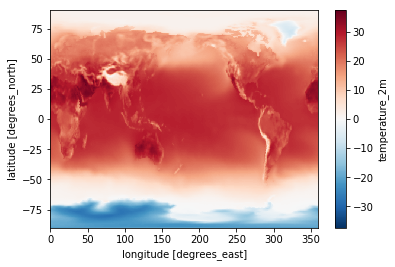

In [10]:
(high_t_reference -273).plot()

## For period of interest, select where t > tref

In [11]:
@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_lengths(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    lengther = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add the length of the accumulator where the sequences are ending and are > 3
        # TODO should the length include the first 3 days?
        lengther[mask & (accumulator > 3)] += accumulator[mask & (accumulator > 3)]
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return lengther

@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_counts(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    counter = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one the the counter where the sequences are ending AND > 3
        counter[mask & (accumulator > 3)] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter


def get_summer_temperatures(year, temperatures):
    t_yr = temperatures.sel(time=f'{year}')
    lat_north = temperatures.latitude[temperatures.latitude >= 0]
    lat_south = temperatures.latitude[temperatures.latitude < 0]
    
    tnh = t_yr.sel(latitude=lat_north)
    tnh = tnh.where(t_yr['time.season'] == 'JJA')

    tsh = t_yr.sel(latitude=lat_south)
    tsh = tsh.where(t_yr['time.season'] == 'DJF')

    
    t_yr = xr.concat([tnh, tsh], 
                     dim='latitude')
    t_yr = t_yr.fillna(-9999)
    return t_yr


def heatwave_length_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_lengths(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_length'
                          )
    
    return counter


def heatwave_count_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_counts(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_count'
                          )
    
    return counter    

In [12]:
heatwaves_counts = xr.concat((heatwave_count_for_year(year, temperatures, high_t_reference) 
                                  for year in tnrange(REFERENCE_YEAR_START, MAX_YEAR+1)), 
                             dim='year').astype(float)


In [8]:
heatwaves_lengths = xr.concat((heatwave_length_for_year(year, temperatures, high_t_reference)
                                   for year in tnrange(REFERENCE_YEAR_START, MAX_YEAR+1)),
                              dim='year').astype(float)

In [9]:
heatwaves_counts.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

### Open saved results

In [94]:
heatwaves_counts = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

# TODO something wierd happening, trying to use oldest version of file

In [52]:
heatwaves_counts = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years_OLD.nc'))

### Calculate historical and delta
### Get the area-weighted time series for counts and lengths

In [53]:
# Take average period to match Temperature Change calculations
heatwaves_counts_historical = heatwaves_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_counts_delta = heatwaves_counts.sel(year=slice(2000, MAX_YEAR)) - heatwaves_counts_historical

In [15]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwaves_counts.latitude))

In [25]:
heatwaves_counts_ts = (heatwaves_counts_delta * cos_lat).mean(dim=['latitude', 'longitude'])

In [23]:
heatwaves_lengths_historical = heatwaves_lengths.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_lengths_delta = heatwaves_lengths.sel(year=slice(2000, MAX_YEAR)) - heatwaves_lengths_historical

In [ ]:
heatwaves_lengths_ts = (heatwaves_lengths_delta * cos_lat).mean(dim=['latitude', 'longitude'])

In [15]:
heatwaves_lengths_ts.to_netcdf(DATA_SRC / 'lancet'/'heatwaves_lengths_delta_ts.nc')

In [26]:
heatwaves_counts_delta = heatwaves_counts_delta.compute()

Save results

In [13]:
# Workaround to allow viewing in Panoply
heatwaves_lengths_delta['year'] = heatwaves_lengths_delta['year'].astype(np.int32)
heatwaves_counts_delta['year'] = heatwaves_counts_delta['year'].astype(np.int32)

heatwaves_lengths_delta.to_netcdf(DATA_SRC / 'lancet'/'heatwaves_lengths_delta.nc')
heatwaves_counts_delta.to_netcdf(DATA_SRC / 'lancet'/'heatwaves_counts_delta.nc')

Load results

In [37]:
heatwaves_lengths_delta = xr.open_dataarray(DATA_SRC / 'lancet'/'heatwaves_lengths_delta.nc')
heatwaves_counts_delta = xr.open_dataarray(DATA_SRC / 'lancet'/'heatwaves_counts_delta.nc')

## Heatwave count plots

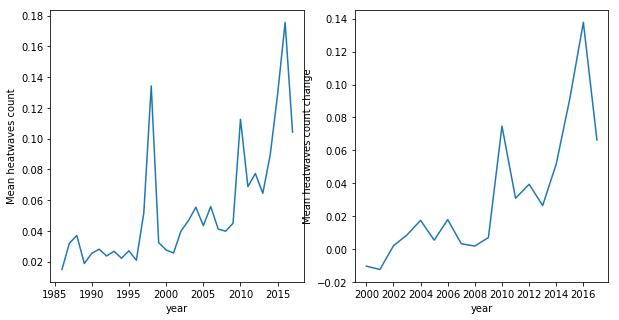

In [26]:
f, axs = plt.subplots(1, 2)
f.set_size_inches(10,5)
ax = axs[0]
(heatwaves_counts * cos_lat).mean(dim=['latitude', 'longitude']).plot(ax=ax)
ax.set_ylabel('Mean heatwaves count')

ax = axs[1]
heatwaves_counts_ts.plot(ax=ax)
ax.set_ylabel('Mean heatwaves count change')
ax.set_xticks(list(range(2000, MAX_YEAR + 1, 2)));


# Project the heatwave changes onto the population

## Heatwaves lengths area mean compared population weighted mean

This is the main purely numeric indicator for heatwaves, since it delivers a simple metric that allows comparison between global average and population weighted average values in terms of number of days of heatwaves.

In [18]:
heatwaves_l_pop_ts = population_tools.project_to_population(heatwaves_lengths_delta, 
                                                            pct_age_rasters, 
                                                            norm=True, 
                                                            end_year=MAX_YEAR)

In [19]:
heatwaves_l_pop_ts = heatwaves_l_pop_ts.compute()

In [17]:
# Save results
heatwaves_l_pop_ts.to_netcdf(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc')

In [16]:
# Retrieve saved results
heatwaves_l_pop_ts = xr.open_dataarray(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc')

In [30]:
heatwaves_lengths_ts.name = 'heatwave_lengths'
heatwaves_l_pop_ts.name = 'heatwave_lengths_pop'

with pd.ExcelWriter(str(RESULTS_FOLDER / 'heatwave_exposure.xlsx')) as writer:

    # output = heatwaves_counts_ts.to_dataframe().join(heatwaves_c_pop_ts.to_dataframe())
    # output.columns = ['Area weighted change N count', 'Exposure weighted change mean N count']

    # output.to_excel(writer, sheet_name='heatwaves_counts')

    output = heatwaves_lengths_ts.to_dataframe().join(heatwaves_l_pop_ts.to_dataframe())
    output.columns = ['Area weighted change (days)', 'Exposure weighted change (days)']

    output.to_excel(writer, sheet_name='heatwaves_lengths')



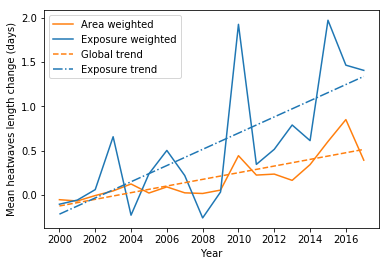

In [31]:
# Plot the change in mean length of heatwaves over time, comparing the global average with the population weighted average
heatwaves_lengths_ts.plot(color='C1',label='Area weighted')
heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted')


anom_reg = stats.linregress(heatwaves_lengths_ts.year.values, heatwaves_lengths_ts.values)
anom_reg = (anom_reg.slope * heatwaves_lengths_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(heatwaves_l_pop_ts.year.values, heatwaves_l_pop_ts.values)
exposures_reg = (exposures_reg.slope * heatwaves_l_pop_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))
plt.xlabel('Year')
plt.ylabel('Mean heatwaves length change (days)')
plt.legend()
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_length_comp_2000-{MAX_YEAR}.png'), dpi=300, bbox_inches='tight')
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_length_comp_2000-{MAX_YEAR}.pdf'), bbox_inches='tight')

## Plot the total number of exposure events where one exposure event = 1 person * 1 heatwave

- Also show the historical average (the baseline against which these are calculated)


# TODO getting different values for the counts total than before??

In [66]:
pct_age_rasters = xr.open_dataarray(DATA_SRC / 'lancet' / 'population_over_65_OLD.nc')

In [ ]:
# Calculate and the gridded exposure (useful for country specific work later)

In [67]:
heatwaves_pop_events = population_tools.project_to_population(heatwaves_counts_delta, 
                                                             pct_age_rasters, 
                                                             norm=False,
                                                             get_ts=False,
                                                             end_year=MAX_YEAR,
                                                              population_file=POP_FILE
                                                             )

In [69]:
heatwaves_pop_events_ts = heatwaves_pop_events.sum(dim=['latitude', 'longitude']).compute()

Save results

In [71]:
heatwaves_pop_events.to_netcdf(DATA_SRC / 'lancet' / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

In [3]:
# heatwaves_pop_events = xr.open_dataarray(DATA_SRC / 'lancet' / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

In [38]:
heatwaves_pop_events = xr.open_dataarray(DATA_SRC / 'lancet' / 'heatwave_exposure_events_2018_report.nc')

# TODO don't save/overwrite the old file until you figure out why the new run gave slightly different results

In [5]:
# Save results
# heatwaves_pop_events_ts.to_netcdf(RESULTS_FOLDER / 'heatwave_exposure_events.nc')
# heatwaves_pop_events_ts.to_dataframe('heatwave_exposure_events').to_csv(RESULTS_FOLDER / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.csv')

In [76]:
# open saved results
heatwaves_pop_events = xr.open_dataarray('heatwave_exposure_events.nc')

Calculate the exposures for the baseline

In [66]:
year = 2000
with population_tools.load_masked_population() as pop:
    heatwave_events_historical = (population_tools.project_param(pop.population.sel(year=year, drop=True), heatwaves_counts_historical) 
                                  * pop.population.sel(year=year, drop=True) 
                                  * pct_age_rasters.sel(year=year, drop=True))
    heatwave_events_historical = heatwave_events_historical.sum(dim=['latitude', 'longitude']).compute()

In [35]:
# with population_tools.PopulationProjector(POP_FILE) as pop:  
#     # For the historical part just take the population in 2000 as a rough mid point to the 1986-2005 range
#     year = 2000
#     heatwave_events_historical = (pop.project(year, heatwaves_counts_historical) * pct_age_rasters.sel(year=year))
#     heatwave_events_historical = (heatwave_events_historical).sum(dim=['latitude', 'longitude']).compute()

In [93]:
25.35552419756908 * 1e6

25355524.19756908

In [36]:
np.asscalar(heatwave_events_historical) / 1e6

25.35552419756908

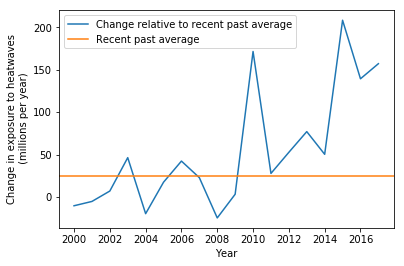

In [39]:
(heatwaves_pop_events_ts / 1e6).plot(label='Change relative to recent past average')
plt.axhline(np.asscalar(heatwave_events_historical) / 1e6, color='C1', label='Recent past average')
plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))
plt.xlabel('Year')
plt.ylabel('Change in exposure to heatwaves\n (millions per year)')

plt.legend()
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_n_exposure_2000-{MAX_YEAR}.png'), dpi=300)
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_n_exposure_2000-{MAX_YEAR}.pdf'), bbox_inches='tight')
